In [1]:
import sys

sys.path.insert(0, '..')

## Setup the Rio Primero project

In [2]:
from morpheus.project.types.Model import Model, SpatialDiscretization
from morpheus.project.types.geometry import Polygon
from morpheus.project.types.discretization.spatial import Grid, Rotation

from morpheus.project.types.Project import Project, Metadata, Name, Description, Tags
from morpheus.project.types.User import UserId

user_id = UserId.new()

project = (Project.new(user_id=user_id).with_updated_metadata(
  metadata=Metadata(
    name=Name('Rio Primero'),
    description=Description('Rio Primero Project in Argentina'),
    tags=Tags.from_list(['rio primero', 'argentina'])
  )
))

model = Model.new()
project = project.with_updated_model(model)
model = project.model

area = Polygon([[
  (-63.687336, -31.313615),
  (-63.687336, -31.367449),
  (-63.56926, -31.367449),
  (-63.56926, -31.313615),
  (-63.687336, -31.313615)
]])

spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=area,
  grid=Grid.cartesian_from_polygon(
    polygon=area,
    n_cols=75,
    n_rows=40,
    rotation=Rotation(0),
  ),
)

model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)
area.centroid()

Point(coordinates=(-63.628298, -31.340532), type='Point')

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

model = model.with_updated_time_discretization(time_discretization=time_discretization)

In [4]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(model.spatial_discretization.geometry.as_geojson()))
m.add_child(folium.GeoJson(model.spatial_discretization.geometry.centroid().as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [5]:
grid = spatial_discretization.grid
cell_geometries = grid.get_wgs_cell_geometries()

n_cols = grid.n_cols()
n_rows = grid.n_rows()

for col in range(n_cols):
  for row in range(n_rows):
    cell_geometry = cell_geometries[row][col]
    folium.GeoJson(cell_geometry.as_geojson()).add_to(m)

m

# Setup Layers

In [6]:
from morpheus.project.types.layers.Layer import LayerName, LayerConfinement, LayerDescription, Layer, LayerProperties

layers = model.layers
first_layer = layers[0]
first_layer.name = LayerName('Top Layer')
first_layer.type = LayerConfinement.convertible()
first_layer.description = LayerDescription('Top Layer')
first_layer.properties = LayerProperties.from_values(
  top=460,
  bottom=450,
  initial_head=460,
  hk=8.64,
  hani=1,
  vka=0.864,
  specific_storage=1e-5,
  specific_yield=0.2,
)

layer = layers.with_updated_layer(first_layer)

second_layer = Layer.from_default()
second_layer.name = LayerName('Aquitard')
second_layer.type = LayerConfinement.confined()
second_layer.description = LayerDescription('Aquitard')
second_layer.properties = LayerProperties.from_values(
  top=450,
  bottom=448,
  initial_head=450,
  hk=10,
  hani=10,
  vka=0.1,
  specific_storage=1e-5,
  specific_yield=0.2,
)

layers = layers.with_added_layer(second_layer)
third_layer = Layer.from_default()
third_layer.name = LayerName('Aquifer')
third_layer.type = LayerConfinement.confined()
third_layer.description = LayerDescription('Aquifer')

third_layer.properties = LayerProperties.from_values(
  top=448,
  bottom=390,
  initial_head=448,
  hk=8.64,
  hani=8.64,
  vka=0.864,
  specific_storage=1e-5,
  specific_yield=0.2,
)

layers = layers.with_added_layer(third_layer)
model = model.with_updated_layers(layers)

layers

LayersCollection(layers=[Layer(layer_id=LayerId(value='4951a31d-7459-4a6a-b917-1314d51433a0'), name=LayerName(value='Top Layer'), description=LayerDescription(value='Top Layer'), confinement=LayerConfinement(type='confined'), properties=LayerProperties(hk=LayerPropertyValues(value=LayerPropertyDefaultValue(value=8.64), raster=None, zones=None), hani=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1), raster=None, zones=None), vka=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.864), raster=None, zones=None), specific_storage=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1e-05), raster=None, zones=None), specific_yield=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.2), raster=None, zones=None), initial_head=LayerPropertyValues(value=LayerPropertyDefaultValue(value=460), raster=None, zones=None), top=LayerPropertyValues(value=LayerPropertyDefaultValue(value=460), raster=None, zones=None), bottom=LayerPropertyValues(value=LayerPropertyDefault

# Setup General Head Boundaries

In [7]:
from morpheus.project.types.boundaries.Observation import ObservationId, ObservationName
from morpheus.project.types.geometry import LineString, Point
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary, BoundaryName
from morpheus.project.types.boundaries.GeneralHeadObservation import GeneralHeadObservation, GeneralHeadRawDataItem, \
  Stage, Conductance

ghb_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('GHB-East'),
  geometry=LineString([
    (-63.57, -31.367),
    (-63.57, -31.314),
  ]),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((-63.57, -31.367)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
          stage=Stage.from_float(455),
          conductance=Conductance.from_float(200),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
          stage=Stage.from_float(455),
          conductance=Conductance.from_float(200),
        ),
      ]
    )
  ]
)

ghb_east.affected_cells = ghb_east.affected_cells.filter(
  lambda cell: spatial_discretization.affected_cells.contains(cell))

model.boundaries.add_boundary(ghb_east)

ghb_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('GHB-West'),
  geometry=LineString([
    (-63.687, -31.367),
    (-63.687, -31.314),
  ]),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((-63.687, -31.367)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
          stage=Stage.from_float(460),
          conductance=Conductance.from_float(200),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
          stage=Stage.from_float(460),
          conductance=Conductance.from_float(200),
        ),
      ]
    )
  ]
)

ghb_west.affected_cells = ghb_west.affected_cells.filter(
  lambda cell: spatial_discretization.affected_cells.contains(cell))

model.boundaries.add_boundary(ghb_west)

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(model.spatial_discretization.geometry.as_geojson()))

m.add_child(folium.GeoJson(ghb_east.as_geojson()))
m.add_child(folium.GeoJson(ghb_east.affected_cells.to_geojson(grid).as_geojson()))

m.add_child(folium.GeoJson(ghb_west.as_geojson()))
m.add_child(folium.GeoJson(ghb_west.affected_cells.to_geojson(grid).as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup well boundaries

In [8]:
from morpheus.project.types.boundaries.Boundary import WellBoundary, BoundaryName
from morpheus.project.types.boundaries.WellObservation import WellRawDataItem, PumpingRate

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Irrigation Well 1'),
  geometry=Point((-63.671125, -31.325009)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Irrigation Well 2'),
  geometry=Point((-63.659952, -31.330144)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Irrigation Well 3'),
  geometry=Point((-63.674691, -31.342506)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Irrigation Well 4'),
  geometry=Point((-63.637379, -31.359613)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Irrigation Well 5'),
  geometry=Point((-63.582069, -31.324063)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-5000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Public Well 1'),
  geometry=Point((-63.625402, -31.329897)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-8000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-8000),
    ),
  ]
))

model.boundaries.add_boundary(WellBoundary.from_geometry(
  name=BoundaryName('Public Well 2'),
  geometry=Point((-63.623027, -31.331184)),
  grid=grid,
  affected_layers=[layers[2].layer_id],
  raw_data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      pumping_rate=PumpingRate.from_float(-8000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      pumping_rate=PumpingRate.from_float(-8000),
    ),
  ]
))

# Setup recharge boundary

In [9]:
from morpheus.project.types.boundaries.Observation import ObservationId
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, RechargeBoundary
from morpheus.project.types.boundaries.RechargeObservation import RechargeRawDataItem, RechargeRate

recharge_boundary = RechargeBoundary.from_geometry(
  name=BoundaryName('Recharge'),
  geometry=Polygon([[
    (-63.687336, -31.313615),
    (-63.687336, -31.367449),
    (-63.56926, -31.367449),
    (-63.56926, -31.313615),
    (-63.687336, -31.313615)
  ]]),
  grid=grid,
  affected_layers=[layers[0].layer_id],
  raw_data=[
    RechargeRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      recharge_rate=RechargeRate.from_float(0.00033),
    ),
    RechargeRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
      recharge_rate=RechargeRate.from_float(0.00033),
    ),
  ],
)

recharge_boundary.affected_cells = recharge_boundary.affected_cells.filter(
  lambda cell: spatial_discretization.affected_cells.contains(cell))

model.boundaries.add_boundary(recharge_boundary)

m.add_child(folium.GeoJson(recharge_boundary.as_geojson()))
m.add_child(folium.GeoJson(recharge_boundary.affected_cells.to_geojson(grid).as_geojson()))
for recharge_boundary.observation in recharge_boundary.observations:
  m.add_child(folium.GeoJson(recharge_boundary.observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

# Setup river boundary

In [10]:
from morpheus.project.types.boundaries.RiverObservation import RiverObservation, RiverRawDataItem, RiverStage, \
  RiverbedBottom, Conductance
from morpheus.project.types.boundaries.Boundary import RiverBoundary

river = RiverBoundary.from_geometry(
  name=BoundaryName('Rio Primero'),
  geometry=LineString([
    (-63.676586151123, -31.367415770489),
    (-63.673968315125, -31.366206539217),
    (-63.67280960083, -31.364704139298),
    (-63.67169380188, -31.363788030001),
    (-63.670706748962, -31.363641451685),
    (-63.669762611389, -31.364154474791),
    (-63.668003082275, -31.365070580517),
    (-63.666973114014, -31.364814071814),
    (-63.666501045227, -31.363788030001),
    (-63.664870262146, -31.362248946282),
    (-63.662981987, -31.360783128836),
    (-63.661994934082, -31.35942722735),
    (-63.66156578064, -31.357741484721),
    (-63.661437034607, -31.355835826222),
    (-63.66014957428, -31.353123861001),
    (-63.658862113953, -31.352500830916),
    (-63.656415939331, -31.352061042488),
    (-63.654913902283, -31.352354235002),
    (-63.653645516024, -31.351764794584),
    (-63.651242256747, -31.349749064959),
    (-63.645467759343, -31.347546983301),
    (-63.64392280695, -31.346594055584),
    (-63.640060425969, -31.342415720095),
    (-63.639030457707, -31.341096207173),
    (-63.637914658757, -31.340949593483),
    (-63.634138108464, -31.341389433866),
    (-63.629417420598, -31.341242820633),
    (-63.627786637517, -31.341829272192),
    (-63.626585007878, -31.343295385094),
    (-63.626070023747, -31.345347904772),
    (-63.625984193059, -31.346374147817),
    (-63.624610902043, -31.346887265141),
    (-63.622636796208, -31.347327077762),
    (-63.621606827946, -31.34813339556),
    (-63.621349335881, -31.349746010418),
    (-63.621349335881, -31.351285298808),
    (-63.620491028996, -31.35238477509),
    (-63.619375230046, -31.352677966594),
    (-63.618345261784, -31.352824562004),
    (-63.616971970769, -31.352604668804),
    (-63.616285325261, -31.351798389339),
    (-63.614997864934, -31.351358597627),
    (-63.612852097722, -31.351798389339),
    (-63.611049653264, -31.351065402009),
    (-63.60898971674, -31.349086307681),
    (-63.607530595036, -31.347473681512),
    (-63.605556489201, -31.346154239536),
    (-63.604955674382, -31.344028432977),
    (-63.60504150507, -31.342928859011),
    (-63.607530595036, -31.341096207173),
    (-63.60959053156, -31.339190211392),
    (-63.608732224675, -31.337650725074),
    (-63.60787391779, -31.336037902868),
    (-63.606586457463, -31.334864923902),
    (-63.60452652094, -31.334718300503),
    (-63.602552415105, -31.335451415212),
    (-63.601608277531, -31.336917627498),
    (-63.600063325139, -31.338237199022),
    (-63.598260880681, -31.338383816938),
    (-63.59602928278, -31.338677052084),
    (-63.595342637273, -31.337724034517),
    (-63.595771790715, -31.336184524211),
    (-63.595771790715, -31.334864923902),
    (-63.595085145207, -31.333691930314),
    (-63.594226838322, -31.332738862259),
    (-63.592767716618, -31.332518922106),
    (-63.591480256291, -31.333471992389),
    (-63.59096527216, -31.334938235515),
    (-63.590793610783, -31.336477766211),
    (-63.590192795964, -31.337870653233),
    (-63.589162827702, -31.338237199022),
    (-63.587446213933, -31.338603743383),
    (-63.585729600163, -31.338310508009),
    (-63.584098817082, -31.337504106016),
    (-63.58255386469, -31.337504106016),
    (-63.580493928166, -31.337577415573),
    (-63.578691483708, -31.336257834797),
    (-63.576998711214, -31.334611387837),
    (-63.575305938721, -31.33296491207),
    (-63.572559356689, -31.332231777991),
    (-63.569641113281, -31.331205380684)
  ]),
  grid=grid,
  affected_layers=[layers[0].layer_id],
  observations=[
    RiverObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((-63.687, -31.367)),
      raw_data=[
        RiverRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
          river_stage=RiverStage.from_float(455),
          conductance=Conductance.from_float(200),
          riverbed_bottom=RiverbedBottom.from_float(453),
        ),
        RiverRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
          river_stage=RiverStage.from_float(455),
          conductance=Conductance.from_float(200),
          riverbed_bottom=RiverbedBottom.from_float(453),
        ),
      ]
    )
  ]
)

river.affected_cells = river.affected_cells.filter(
  lambda cell: spatial_discretization.affected_cells.contains(cell))

model.boundaries.add_boundary(river)

In [11]:
m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(model.spatial_discretization.geometry.as_geojson()))

m.add_child(folium.GeoJson(model.boundaries.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [12]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.types.Mf2005CalculationEngineSettings import \
  Mf2005CalculationEngineSettings
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_engine_settings = Mf2005CalculationEngineSettings.default()
calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [13]:
import json
json.dumps(model.boundaries.to_dict())

'[{"id": "15ae8015-4c70-4e7f-a57c-b3709eb8bba5", "type": "general_head", "name": "GHB-East", "geometry": {"type": "LineString", "coordinates": [[-63.57, -31.367], [-63.57, -31.314]]}, "affected_cells": {"type": "sparse", "shape": [40, 75], "data": [[74, 0], [74, 1], [74, 2], [74, 3], [74, 4], [74, 5], [74, 6], [74, 7], [74, 8], [74, 9], [74, 10], [74, 11], [74, 12], [74, 13], [74, 14], [74, 15], [74, 16], [74, 17], [74, 18], [74, 19], [74, 20], [74, 21], [74, 22], [74, 23], [74, 24], [74, 25], [74, 26], [74, 27], [74, 28], [74, 29], [74, 30], [74, 31], [74, 32], [74, 33], [74, 34], [74, 35], [74, 36], [74, 37], [74, 38], [74, 39]]}, "affected_layers": ["4127fefe-eabd-4740-8c04-b671c3e0b159"], "observations": [{"observation_id": "392c512f-60ab-4f1a-89c1-388ddf90d767", "observation_name": "Observation Point 1", "geometry": {"type": "Point", "coordinates": [-63.57, -31.367]}, "raw_data": [{"date_time": "2015-01-01T00:00:00+00:00", "stage": 455, "conductance": 200}, {"date_time": "2020-12-

In [14]:
calculation = Calculation.from_dict(calculation.to_dict())

In [15]:
calculation.calculation_id

CalculationId(value='21655ec6-ea46-415b-92a6-15f633adca69')

In [16]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='149746b9-8732-46c3-9ff5-c4fabfa2395f'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(-63.687336, -31.313615), (-63.687336, -31.367449), (-63.56926, -31.367449), (-63.56926, -31.313615), (-63.687336, -31.313615)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(-63.68733600000001, -31.31361499999999), type='Point'), col_widths=[175.2116553981148, 175.2116553981148, 175.21165539811483, 175.21165539811477, 175.21165539811489, 175.21165539811477, 175.21165539811477, 175.21165539811477, 175.21165539811477, 175.211655398115, 175.21165539811477, 175.21165539811477, 175.211655398115, 175.21165539811454, 175.21165539811454, 175.211655398115, 175.211655398115, 175.21165539811454, 175.211655398115, 175.211655398115, 175.211655398115, 175.21165539811454, 175.21165539811454, 175.211655398115, 175.211655398115, 175.211655398115, 175.2116553981141, 175.211655398115, 175.211655398115, 175.2116553981141, 175.211655398115, 175.211655398

In [17]:
result = calculation_service.get_result()
result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['149746b9-8732-46c3-9ff5-c4fabfa2395f.bas', '149746b9-8732-46c3-9ff5-c4fabfa2395f.nam', '149746b9-8732-46c3-9ff5-c4fabfa2395f.lpf', '149746b9-8732-46c3-9ff5-c4fabfa2395f.ghb', '149746b9-8732-46c3-9ff5-c4fabfa2395f.rch', '149746b9-8732-46c3-9ff5-c4fabfa2395f.dis', '149746b9-8732-46c3-9ff5-c4fabfa2395f.oc', '149746b9-8732-46c3-9ff5-c4fabfa2395f.hds', '149746b9-8732-46c3-9ff5-c4fabfa2395f.wel', '149746b9-8732-46c3-9ff5-c4fabfa2395f.riv', '149746b9-8732-46c3-9ff5-c4fabfa2395f.pcg', '149746b9-8732-46c3-9ff5-c4fabfa2395f.list'], head_results=AvailableResults(times=[2191.0], kstpkper=[(0, 0)], number_of_layers=3, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[2191.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


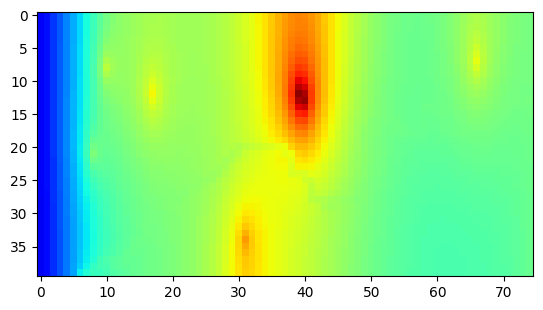

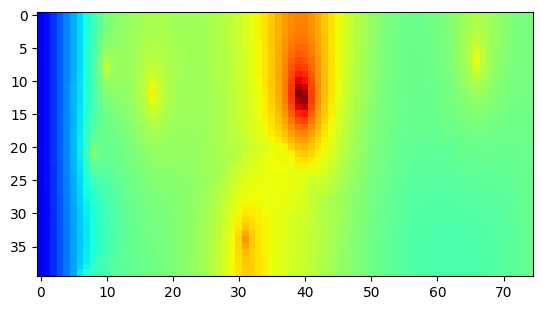

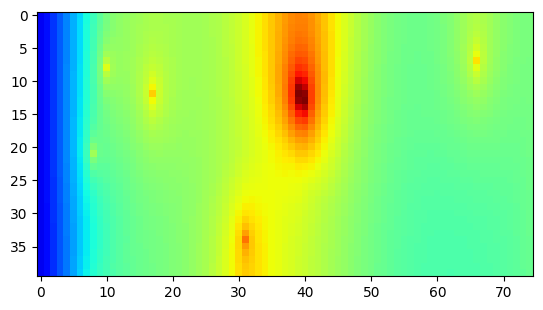

In [18]:
import matplotlib.pyplot as plt

for layer_idx in range(calculation_service.get_result().head_results.number_of_layers):
  heads = calculation_service.read_head(0, layer_idx)
  plt.imshow(heads, cmap='jet_r', vmin=450, vmax=460)
  plt.show()